# Aula 18 &mdash; Classificação pelos K vizinhos mais próximos e Métricas de avaliação

Renato Vimieiro

rv2 {em} cin.ufpe.br

maio 2017

## KNN &dash; K vizinhos mais próximos

O método supervisionado de classificação pelos $k$ vizinhos mais próximos é talvez o método mais simples de classificação. Como vimos os classificadores Naive Bayes e Análise de discriminantes consistem em ajustar modelos para estimar a probabilidade condicional $P(c_i~|~X)$. Os classificadores para isso supunham que os atributos seguiam alguma distribuição pré-definida (e.g. normal). O KNN, por outro lado, estima essa probabilidade a partir dos dados. A ideia é usar os $k$ vizinhos mais próximos da amostra a ser classificada para tomar a decisão.

A definição de vizinhos mais próximos é dada por uma função de distância (em geral, Euclidiana, mas qualquer distância é válida). A distância $\delta(X,X_i)$ é a distância Euclidiana entre a amostra a ser classificada $X$ e uma amostra do conjunto de treinamento $X_i$ no espaço p-dimensional. Mais precisamente,

$$
\delta(X,X_i) = ||X-X_i||_2 = \sqrt{\sum (X_j - X_{ij})^2}
$$

Pode-se demonstrar (ver Zaki e Meira Jr. seção 18.3) que 

$$
P(c_i~|~X) = \frac{K_i}{K}
$$

onde $K_i$ é a quantidade de vizinhos da classe $c_i$ entre os $K$ vizinhos mais próximos de $X$.

Logo, a classe predita para a amostra $X$ é

$$
\hat{y} = argmax{P(c_i~|~X)} = argmax{\frac{K_i}{K}} = argmax{K_i}
$$

Em outras palavras, o kNN atribui a $X$ a classe da maioria de seus vizinhos mais próximos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
prostate = pd.read_csv("http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data",
                       header=0,index_col=0,sep='\t')
prostate['prognostico'] = prostate.gleason.map(lambda x: x >=7 and 'mau' or 'bom')
treino = prostate[prostate.train=='T'].drop('train',axis=1)
teste = prostate[prostate.train=='F'].drop('train',axis=1)

In [184]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=4)
attrs = ['lpsa','lcavol','lweight','lcp','lbph','svi']
model.fit(treino[attrs],treino.prognostico.map(lambda x: x=='mau' and 1 or 0))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [17]:
pd.crosstab(model.predict(treino[attrs]),treino.prognostico)

prognostico,bom,mau
row_0,,
0,20,10
1,5,32


In [18]:
pd.crosstab(model.predict(teste[attrs]),teste.prognostico)

prognostico,bom,mau
row_0,,
0,8,7
1,2,13


## Métricas de avaliação de classificadores

Como havíamos discutido antes, a tabela de contingência nos permite calcular diversas métricas de qualidade. Segue uma lista das métricas mais usadas

- **acurácia**: $(TP+TN)/(TP+FP+TN+FN)$
- **taxa de erro**: $(FP+FN)/(TP+FP+TN+FN)$
- **precisão**: $TP/(TP+FP)$
- **revocação/cobertura/sensitividade**: $TP/(TP+FN)$
- **especificidade**: $TN/(FP+TN)$
- **F-measure**: $2(precisao*sensitividade)/(precisao + sensitividade) = 2TP/(2TP+FP+FN)$ (média harmônica da precisão e sensitividade)
- **MCC (Matthew's Correlation Coefficient)**: $(TP*TN-FP*FN)/\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}$ 

A F-measure é uma boa métrica de avaliação pois leva em consideração a precisão do modelo em classificar corretamente as amostras positivas (mostra o quanto ele acerta e quantas amostras positivas ele classifica como tal). Seu valor máximo é 1, exatamente quando o modelo consegue classificar corretamente todas as amostras (FP=FN=0).

O MCC também é bastante valioso principalmente quando há um desbalanço na distribuição das classes. Seu valor varia de -1 a +1, sendo +1 perfeita classificação, 0 aleatória, e -1 classificação completamente oposta.

A maior parte dessas métricas podem ser computadas diretamente em `sklearn`.

In [185]:
from sklearn.metrics import matthews_corrcoef, classification_report, accuracy_score
pred_teste = model.predict(teste[attrs])
pred_treino = model.predict(treino[attrs])
real_teste = teste.prognostico.map(lambda x: x=='mau' and 1 or 0)
real_treino = treino.prognostico.map(lambda x: x=='mau' and 1 or 0)
print(classification_report(real_treino,pred_treino,target_names=['bom','mau']))
print('MCC treino = {:.3f}, Acuracia treino = {:.3f}'.format(matthews_corrcoef(real_treino,pred_treino),
                                                            accuracy_score(real_treino,pred_treino)))
print(classification_report(real_teste,pred_teste,target_names=['bom','mau']))
print('MCC teste = {:.3f}, Acuracia teste = {:.3f}'.format(matthews_corrcoef(real_teste,pred_teste),
                                                            accuracy_score(real_teste,pred_teste)))

             precision    recall  f1-score   support

        bom       0.67      0.80      0.73        25
        mau       0.86      0.76      0.81        42

avg / total       0.79      0.78      0.78        67

MCC treino = 0.547, Acuracia treino = 0.776
             precision    recall  f1-score   support

        bom       0.53      0.80      0.64        10
        mau       0.87      0.65      0.74        20

avg / total       0.76      0.70      0.71        30

MCC teste = 0.424, Acuracia teste = 0.700


Outra métrica muito popular é a curva ROC (Receive Operating Characteristic). Essa curva mostra a relação entre a proporção de verdadeiros positivos (sensibilidade) e falsos positivos (FPR=FP/FP+TN) quando se varia os limiares de corte para classificação. Como vimos, alguns modelos usam um limiar na probabilidade condicional $P(c_i~|~X)$ para classificar as amostras como positivas e negativas. Cada limiar escolhido resulta em um valor de sensibilidade e FPR. Os limiares são escolhidos com base nas probabilidades de pertencerem à classe positiva das $m$ amostras. Os valores são variados da menor pra maior probabilidade.

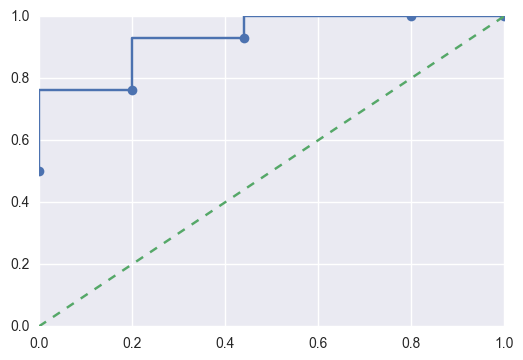

In [195]:
fpr, tpr, thresholds = roc_curve(treino.prognostico.map(lambda x: x=='mau' and 1 or 0),
                                 model.predict_proba(treino[attrs])[:,1],
                                 drop_intermediate=False)
plt.plot(fpr,tpr, marker='o', drawstyle='steps')
plt.plot(fpr,fpr,linestyle='--')

Podemos interpretar esse gráfico da seguinte forma. O ideal é estarmos o mais próximo possível do canto esquerdo superior. Pontos acima da linha tracejada indicam uma predição melhor que aleatória (sobre a linha). Finalmente, podemos resumir o desempenho do classificador calculando a área sob a curva ROC (AUC). Como a área do gráfico é 1, a AUC será um valor entre 0 e 1.

In [196]:
from sklearn.metrics import roc_auc_score
roc_auc_score(teste.prognostico.map(lambda x: x=='mau' and 1 or 0),
                                 model.predict_proba(teste[attrs])[:,1])

0.86749999999999994

Assim, como o valor é próximo de 1, concluimos que o classificador teve um bom desempenho.

Finalmente, podemos avaliar o desempenho do classificador testando a hipótese de que a classe predita e a classe real são independentes e não estão relacionadas. Para isso, podemos usa o teste do $\chi^2$.

O teste avalia se a diferença entre os valores observados e esperados (sob a hipótese de independência) na tabela de contigência através da estatística $\chi^2$.

O valor esperado para a célula $E_{ij}$ é dado por

$$
E_{ij} = \frac{R_iC_j}{N}
$$

A estatística $\chi^2$ é dada por

$$
\chi^2 = \sum_i^k\sum_j^k\frac{O_{ij}-E_{ij}}{E_{ij}}
$$

Depois avalia-se a probabilidade de se observar uma estatística tão alta quanto a calculada usando a distribuição $\chi^2$. Se o valor for suficientemente pequeno, rejeita-se a hipótese nula, ou seja, aceita-se que existe relação entre as classes preditas e reais.

In [70]:
tabcont = pd.crosstab(model.predict(teste[attrs]),teste.prognostico)
print(tabcont)
cols = tabcont.sum(axis=0).values
print(cols)
rows = tabcont.sum(axis=1).values
print(rows)

prognostico  bom  mau
row_0                
0              7    2
1              3   18
[10 20]
[ 9 21]


In [89]:
exp = np.fromiter([cols[j]*rows[i]/np.sum(cols) for i in [0,1] for j in [0,1]],dtype='float').reshape(2,2)
exp

array([[  3.,   6.],
       [  7.,  14.]])

In [112]:
chisq = np.sum((tabcont.values-exp)**2/exp)
chisq

11.428571428571427

In [114]:
from scipy.stats import chi2_contingency
from scipy.stats.distributions import chi2
chi2.sf(chisq,df=1)

0.00072323271643019336

In [116]:
chi2_contingency(tabcont.values,correction=False)

(11.428571428571427, 0.00072323271643019336, 1, array([[  3.,   6.],
        [  7.,  14.]]))

Como o p-value é menor que 0.05, rejeitamos a hipótese de independência e concluimos que há relação entre o valor predito e o valor real.

## Investigando a correção dos rótulos

Todas as métricas de qualidade discutidas acima assumem que os rótulos do conjunto de treinamento são corretos. Podemos analisar a correção dos rótulos, avaliando a concordância na atribuição dos rótulos por vários classificadores. Se houver alta concordância na atribuição dos rótulos, temos mais indícios de que os rótulos são corretos.

Existem diversas métricas para se quantificar o nível de concordância entre os rótulos atribuidos por diversos codificadores (classificadores). Entre essas métricas as mais conhecidas são [Fleiss Kappa](https://en.wikipedia.org/wiki/Fleiss%27_kappa) e [Krippendorf alpha](https://en.wikipedia.org/wiki/Krippendorff%27s_alpha).

O Fleiss Kappa possui uma escala de valores associados que facilita sua compreensão (veja o artigo da Wikipedia). Logo, focaremos nela nessa aula. Imagine que possuimos $n$ amostras que serão classificadas em $k$ classes por $m$ codificadores. O Fleiss Kappa informa o quanto a probabilidade/proporção média de concordância desvia do valor esperado. Formalmente,

$$
\kappa = \frac{\bar{P}-\bar{P_e}}{1-\bar{P_e}}
$$

A probabilidade de concordância esperada é o valor esperado sobre todas as classes

$$
\bar{P_e} = \sum_j^k p_j^2 = \sum_j^k(\frac{1}{nm} \sum_i n_{ij})^2
$$

A probabilidade de concordância observada para cada amostra é dada pela proporção de pares de classificadores que concordam na atribuição da classe sobre o total de pares.

$$
P_i = \frac{1}{m(m-1)}\sum_j^km_{ij}(m_{ij}-1)
$$

Assim, a probabilidade de concordância média observada é dada por:

$$
\bar{P} = \frac{1}{n}\sum P_i = \frac{1}{n}\sum_i^n\frac{1}{m(m-1)}\sum_j^km_{ij}(m_{ij}-1) = \frac{1}{nm(m-1)}\sum_i^n\sum_j^km_{ij}^2-nm
$$

Quando $\bar{P}$ é menor ou igual a $\bar{P_e}$, temos uma concordância simplesmente por chance e $\kappa \leq 0$. Por outro lado, $\kappa = 1$ indica que todos os classificadores concordam com as classes atribuídas. A escala de interpretação proposta por [Landis e Koch (1977)](www.jstor.org/stable/2529310) é a seguinte:


| ${\displaystyle \kappa }$ | Interpretation |
|-------------------------|----------------|
|< 0 |	Poor agreement|
|0.01 – 0.20 |	Slight agreement|
|0.21 – 0.40 |	Fair agreement|
|0.41 – 0.60 |	Moderate agreement|
|0.61 – 0.80 |	Substantial agreement|
|0.81 – 1.00 |	Almost perfect agreement|

Podemos aplicar essa metodologia para avaliar os rótulos das amostras de nosso exemplo. Para isso, vamos avaliar a concordância de várias classificadores e a classe real.

In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

models = [DecisionTreeClassifier(), RandomForestClassifier(min_samples_leaf=5,n_estimators=100),
         ExtraTreesClassifier(min_samples_leaf=5,n_estimators=100),LogisticRegression(), GaussianNB(),
         KNeighborsClassifier(n_neighbors=3)]
attrs = ['lpsa','lcavol','lweight','lcp','lbph']
models = map(lambda x: x.fit(treino[attrs],
                             treino.prognostico.map(lambda x: x=='mau' and 1 or 0)), models)
import re
prediction = pd.DataFrame(dict(map(lambda x: (re.sub('.*\.','',str(type(x))).rstrip("'>"),
                                              x.predict(treino[attrs])),models)))
prediction['prognostico'] = treino.prognostico.map(lambda x: x=='mau' and 1 or 0).values
prediction.index = treino.index
prediction.head()

,DecisionTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,LogisticRegression,RandomForestClassifier,prognostico
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0


In [164]:
from nltk.metrics.agreement import AnnotationTask
at = AnnotationTask(data=[(coder,item,prediction.loc[item,coder]) for coder in prediction.columns for item in prediction.index])
at.kappa()

0.6939258734741154

De acordo com a tabela, temos concordância substancial acerca dos rótulos atribuídos pelos codificadores.
De qualquer forma, podemos ainda verificar quais são as amostras onde houve maior discordância entre os classificadores e o rótulo real, e no geral.

In [170]:
geral = prediction.apply(lambda x: x.value_counts(),axis=1).dropna()
geral

,0,1
3,5.0,2.0
13,2.0,5.0
14,5.0,2.0
17,5.0,2.0
18,3.0,4.0
27,5.0,2.0
30,2.0,5.0
33,4.0,3.0
35,6.0,1.0
38,2.0,5.0


In [183]:
pd.merge(treino.loc[geral.index.values.tolist(),['gleason','prognostico']],geral,left_index=True,right_index=True)

,gleason,prognostico,0,1
3,7,mau,5.0,2.0
13,7,mau,2.0,5.0
14,7,mau,5.0,2.0
17,7,mau,5.0,2.0
18,6,bom,3.0,4.0
27,7,mau,5.0,2.0
30,6,bom,2.0,5.0
33,6,bom,4.0,3.0
35,6,bom,6.0,1.0
38,7,mau,2.0,5.0
